# Ornstein Uhlenbeck Process - Efe Dikmen

Sources:

* Stochastic Calculus Lectures at NYU from Professor Alexey Kuptsov

* https://towardsdatascience.com/stochastic-processes-simulation-the-ornstein-uhlenbeck-process-e8bff820f3

* https://towardsdatascience.com/stochastic-processes-simulation-brownian-motion-the-basics-c1d71585d9f9

# 1. Introduction

In this notebook, we will simulate an Ornstein Uhlenbeck process. First let's look at the how the process is formulated:

Given $\alpha,\sigma>0$ and $B_t$ Brownian Motion:

$$dX_t=\alpha(\beta-X_t)dt+\sigma dB_t$$

is satisfied by the Ornstein Uhlenbeck process $X_t$. Observe that:

- The $\alpha$ parameter governs the rate of mean reversion

- The $\beta$ parameter is the long term mean of the process

- The $\sigma$ parameter governs the magnitude of fluctuations of the process.

# 2. Solution ot the Ornstein Uhlenbeck Process

We start with the below equation and use Ito's Product Rule:

$$d(e^{\alpha t}X_t)=\alpha e^{\alpha t}X_tdt+e^{\alpha t}dX_t+de^{\alpha t}dX_t$$

we know that $de^{\alpha t}=\alpha e^{\alpha t}dt$
and that $dX_t=\alpha(\beta-X_t)dt+\sigma dB_t$. Then using the conventions for multiplying the differentials:

$$de^{\alpha t}dX_t=(\alpha e^{\alpha t}dt)(\alpha(\beta-X_t)dt+\sigma dB_t)=0$$

Inserting this result and the definition of $dX_t$ back into the first equation:

$$\implies d(e^{\alpha t}X_t)=\alpha e^{\alpha t}X_tdt+e^{\alpha t}(\alpha(\beta-X_t)dt+\sigma dB_t)$$

$$\implies d(e^{\alpha t}X_t)=\alpha\beta e^{\alpha t} d_t+\sigma e^{\alpha t} dB_t$$

Thus we get that:

$$e^{\alpha t}X_t-X_0=\int_0^t \alpha\beta e^{\alpha s} d_s +\sigma\int_0^t e^{\alpha s} dB_s$$

$$\implies e^{\alpha t}X_t=X_0+\beta(e^{\alpha t}-1)+\sigma\int_0^t e^{\alpha s} dB_s$$

$$\implies X_t=X_0e^{-\alpha t}+\beta(1-e^{-\alpha t})+\sigma \int_0^t e^{\alpha (s-t)} dB_s$$

is the solution satisfying the Ornstein Uhlenbeck Process.

# 3. Distribution of the Ornstein Uhlenbeck Process

Since the expectation of the Ito integral is 0:

$$\mathbb{E}[X_t]=X_0e^{-\alpha t}+\beta(1-e^{-\alpha t})$$

Now calculating the variance:

$$\text{Var}(X_t)=Var(\sigma \int_0^t e^{\alpha (s-t)} dB_s)=\sigma^2e^{-2\alpha t}\text{Var}(\int_0^t e^{\alpha s} dB_s)$$

Using the fact that $\mathbb{E}[\int_0^t e^{\alpha s} dB_s]=0$, we have that $\text{Var}(\int_0^t e^{\alpha s} dB_s)=\mathbb{E}\bigg[\bigg(\int_0^t e^{\alpha s} dB_s\bigg)^2\bigg]$. Then using Ito's isometry:

$$\implies \text{Var}(X_t)=\sigma^2e^{-2\alpha t}\mathbb{E}\bigg[ \int_0^t e^{2\alpha s} ds\bigg]=\sigma^2e^{-2\alpha t}\big(\frac{e^{2\alpha t}-1}{2\alpha}\big)=\frac{\sigma^2}{2\alpha}(1-e^{-2\alpha t})$$

Thus it follows that $X_t\sim\mathcal{N}\bigg(X_0e^{-\alpha t}+\beta(1-e^{-\alpha t}),\frac{\sigma^2}{2\alpha}(1-e^{-2\alpha t})\bigg)$

Notice as $\alpha\to\infty$:
$X_t\xrightarrow[]{d}\mathcal{N}\bigg(\beta,\frac{\sigma^2}{2\alpha}\bigg)$

# 4. Simulation

## a. Defining the required functions:

In [1]:
from dataclasses import dataclass
from typing import Optional
import numpy as np

@dataclass 
class OUParams:
    alpha: float # mean reversion parameter
    beta: float # long run mean
    sigma: float # fluctuation scaling parameter

First we will simulate Brownian Motion

In [2]:
def dBt(T: int, random_state: Optional[int] = None) -> np.ndarray:
    '''
    Simulates Brownian Motion increments dB_t for T times 
    random_state allows for the use of the same randomness seed
    '''   
    np.random.seed(random_state)
    return np.random.normal(0.0, 1.0, size=T)
    
def Bt(T: int, random_state: Optional[int] = None) -> np.ndarray:
    '''
    Simulates Brownian Motion by cumulative summing increments  
    random_state allows for the use of the same randomness seed
    '''  
    dB_t = dBt(T, random_state)
    B_t = dB_t.cumsum()
    return np.insert(B_t, 0, 0)[:-1]

In [12]:
def OU_process(T: int, params: OUParams, X_0: Optional[float] 
               = None, random_state: Optional[int] = None) -> np.ndarray:
    """
    Generates iterations for T times.
    params is an instance of OUParams dataclass.
    X_0 is the initial value. If None, then X_0 is taken
        to be beta, the long run mean.
    Returns a 1D array.
    """
    t = np.arange(T, dtype=np.float128)
    if not X_0:
        X_0 = params.beta
    nonrandom = X_0 * np.exp(- params.alpha * t) + params.beta * (1 - np.exp(- params.alpha * t))
    dB_t = dBt(T, random_state)
    return nonrandom + params.sigma * np.exp(- params.alpha * t) * ito_integral(t, dB_t, params)

def ito_integral(t: np.ndarray, dB_t: np.ndarray, params: OUParams) -> np.ndarray:
    """
    Calculates the Ito integral in the solution to the OU process
    """
    integral = np.cumsum(np.exp(params.alpha * t)* dB_t)
    return np.insert(integral, 0, 0)[:-1]
    

## b. Simulating the Ornstein Uhlenbeck process

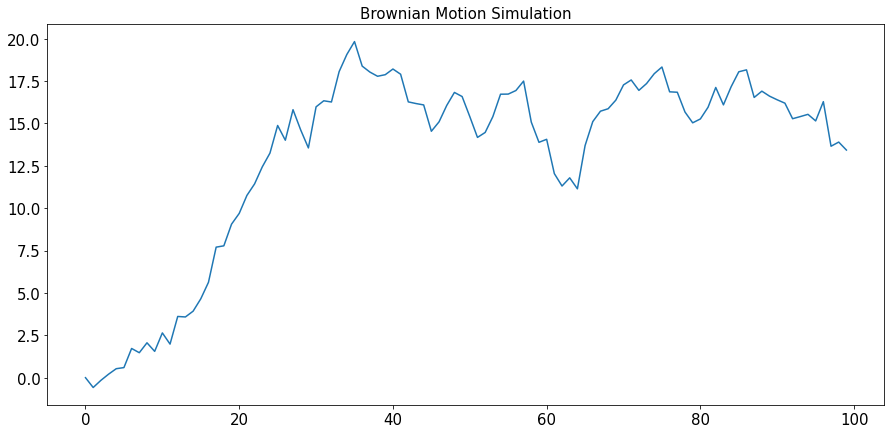

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,7))

title = "Brownian Motion Simulation"

BM = Bt(100)

plt.plot(BM)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

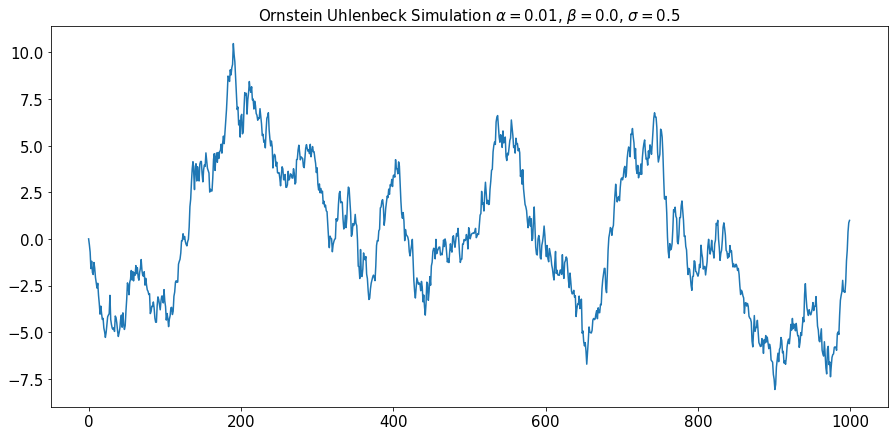

In [17]:
fig = plt.figure(figsize=(15,7))

title = "Ornstein Uhlenbeck Simulation " + r"$\alpha=0.01$, $\beta=0.0$, $\sigma=0.5$"

OU_params = OUParams(alpha=0.01, beta=0.0, sigma=0.5)
OU = OU_process(1000, OU_params)

plt.plot(OU)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()